# 0. Imports and functions

In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

import math
import json

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np

from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.scripts.eval import eval_setup
from nerfstudio.models.instant_ngp import NGPModel

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def image_to_tensor(image_path, device) -> torch.Tensor:
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")

    # Define the transform to convert the image to a PyTorch tensor
    transform = transforms.ToTensor()  # This will convert to a tensor with shape (C, H, W)

    # Apply the transform
    tensor = transform(image)  # Shape will be (3, 512, 512)

    # Permute the tensor to get shape (512, 512, 3)
    tensor = tensor.permute(1, 2, 0).to(device)

    return tensor.detach().requires_grad_(False)

def show_image(tensor):
    plt.figure(figsize=(5, 5))
    plt.imshow(np.array(tensor))
    plt.axis('off')
    plt.show()

In [3]:
!ls

cameras		 main.py	 optimization_progress.png  version_testing.py
data		 misc		 outputs
iteration_0.png  nerf_inversion  paper
loss_curve.png	 notebooks	 README.md


# 1. Setup

In [4]:
# Loading the pre-trained NeRF model 
config_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")
nerf_model = pipeline.model
assert isinstance(nerf_model, NGPModel), "pipeline.model is not of type NGPModel"
nerf_device = nerf_model.device
nerf_device

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

device(type='cuda', index=0)

In [5]:
# This is a bit convoluted step, but it's the only way I found to get the camera parameters
# TODO: Find a better way to do this
dataparser_transforms_path = Path(
    "/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/dataparser_transforms.json")

with open(dataparser_transforms_path, "r") as f:
    dataparser_transform = json.load(f)

dataparser_matrix = torch.tensor(dataparser_transform["transform"], dtype=torch.float32)
dataparser_matrix = np.vstack((dataparser_matrix, np.array([[0, 0, 0, 1]])))
dataparser_scale = dataparser_transform["scale"]

In [6]:
# Hardcoded initial transformation matrix
# TODO: Find a way to automatically generate a starting point instead of relying on a hardcoded one
data_transform_matrix = np.array([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
])

camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "k1": 0,
    "k2": 0,
    "k3": 0,
    "k4": 0,
    "p1": 0,
    "p2": 0,
    "is_fisheye": False,
    "cx": 256.0,
    "cy": 256.0,
    "w": 512,
    "h": 512,
    "aabb_scale": 32,
}

In [7]:
# The camera object expects an input matrix to be transformed to the camera coordinate system
final_matrix = np.dot(dataparser_matrix, data_transform_matrix)
final_matrix[:3, 3] = final_matrix[:3, 3] * dataparser_scale

final_matrix_sliced = torch.tensor(final_matrix, dtype=torch.float32)[:3, :4]
final_matrix_param = nn.Parameter(final_matrix_sliced, requires_grad=True)

final_matrix_param, final_matrix_param.shape

(Parameter containing:
 tensor([[-0.2205, -0.2182, -0.9507, -0.1176],
         [-0.9667,  0.1784,  0.1833,  0.2320],
         [ 0.1296,  0.9595, -0.2502, -0.2692]], requires_grad=True),
 torch.Size([3, 4]))

In [8]:
# Creating a camera object to render images

camera = Cameras(
    camera_to_worlds=final_matrix_param.unsqueeze(0), # 1x3x4 tensor
    fx=camera_params["fl_x"],
    fy=camera_params["fl_y"],
    cx=camera_params["cx"],
    cy=camera_params["cy"],
    camera_type=CameraType.PERSPECTIVE,
    height=camera_params["h"],
    width=camera_params["w"],
)

In [9]:
nerf_model.train(True)

for param in nerf_model.parameters():
    param.requires_grad = False
    
nerf_model.zero_grad()

In [11]:
outputs = nerf_model.get_outputs_for_camera(camera)
generated_rgb = outputs["rgb"]
generated_rgb.device

device(type='cpu')

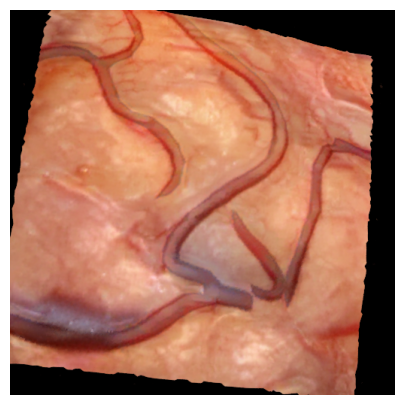

In [12]:
plt.figure(figsize=(5, 5))
plt.imshow(np.array(generated_rgb))
plt.axis('off')
plt.show()

# 2. Training

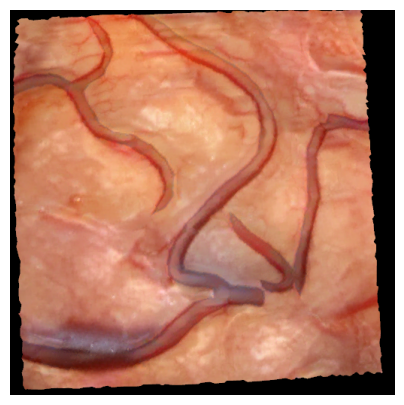

(torch.Size([512, 512, 3]), False, device(type='cuda', index=0))

In [15]:
# Step 1: Get the target image
target_image = image_to_tensor("/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png", device=nerf_model.device)
show_image(target_image.cpu())
target_image.shape, target_image.requires_grad, target_image.device

In [16]:
final_matrix_param

Parameter containing:
tensor([[-0.2205, -0.2182, -0.9507, -0.1176],
        [-0.9667,  0.1784,  0.1833,  0.2320],
        [ 0.1296,  0.9595, -0.2502, -0.2692]], requires_grad=True)

/tmp/ipykernel_3278246/424804541.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  camera.camera_to_worlds = torch.tensor(final_matrix_param, dtype=torch.float32, device=nerf_device)


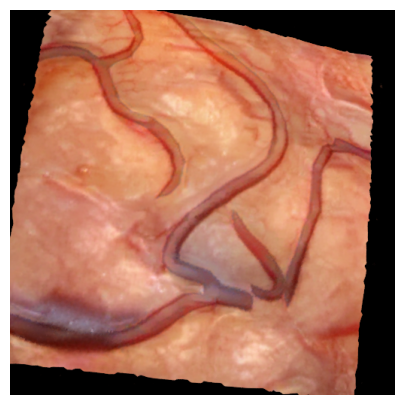

(torch.Size([512, 512, 3]), True, device(type='cuda', index=0))

In [17]:
# Step 2: Get the starting image
camera = pipeline.datamanager.train_dataset.cameras[0].to(nerf_device)
# camera.camera_to_worlds = torch.tensor(final_matrix_param, dtype=torch.float32, device=nerf_device)
camera.camera_to_worlds = final_matrix_param.clone()

rendered_image = nerf_model.get_outputs_for_camera(camera)["rgb"]
rendered_image.requires_grad = True
show_image(rendered_image.cpu().detach().numpy())
rendered_image.shape, rendered_image.requires_grad, rendered_image.device

In [18]:
print("rendered image details: ", rendered_image.shape, rendered_image.requires_grad, rendered_image.device)
print("target image details: ", target_image.shape, target_image.requires_grad, target_image.device)

rendered image details:  torch.Size([512, 512, 3]) True cuda:0
target image details:  torch.Size([512, 512, 3]) False cuda:0


In [19]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW([final_matrix_param])

loss = loss_fn(rendered_image, target_image)

In [20]:
camera = pipeline.datamanager.train_dataset.cameras[0].to(nerf_device)
camera.camera_to_worlds = final_matrix_param.clone()
nerf_model = nerf_model.train()
target_image = image_to_tensor("/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png", device=nerf_model.device)

for i in range(10):
    # Create camera with final_matrix_param every iteration to maintain gradient connection
    camera = Cameras(
        camera_to_worlds=final_matrix_param.unsqueeze(0),  # Keep batch dimension
        fx=camera_params["fl_x"],
        fy=camera_params["fl_y"],
        cx=camera_params["cx"],
        cy=camera_params["cy"],
        camera_type=CameraType.PERSPECTIVE,
        height=camera_params["h"],
        width=camera_params["w"],
    ).to(nerf_device)
    
    # Get rendered image
    outputs = nerf_model.get_outputs_for_camera(camera)
    rendered_image = outputs["rgb"].to(nerf_device)
    
    # Calculate loss
    loss = loss_fn(rendered_image, target_image)
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    print(f"Iteration {i}: Loss = {loss.item()}")
    
    # Optionally visualize progress every few iterations
    if i % 5 == 0:
        show_image(rendered_image.cpu().detach().numpy())

RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn